In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import json
import datetime
import time
import jsonlines
from PIL import Image
from scipy.optimize import curve_fit
import scipy as sy
import pickle as pkl
import seaborn as sns
from os.path import join as oj
import sklearn.model_selection
import sklearn.linear_model
import numpy.linalg as npl
import pandas as pd
import viz
from tqdm import tqdm
from scipy import optimize
import scipy.stats
import torch
import models
import util
import style
import losses

PROCESSED_DIR = 'processed'
RESULTS_DIR = 'results'
DIRECTIONS_DIR = '../data/annotation-dataset-stylegan2/linear_models/new' # path to many datasets, includes on directory before the below dirs
GENERATING_LATENTS_DIR = '../data/annotation-dataset-stylegan2/data'

# loading

**load gt latents**

In [2]:
latents = np.load(oj(GENERATING_LATENTS_DIR, 'W.npy'))

**load annotations in different directions**

In [20]:
annotations_dict = pkl.load(open(oj(PROCESSED_DIR, '01_annotations_dict.pkl'), 'rb'))
annotations_dict_names = pkl.load(open(oj(PROCESSED_DIR, '01_annotations_labels_dict.pkl'), 'rb'))

# rename keys
annotations_dict = {k.replace('calibration-random-v2-', '').replace('-000', ''): annotations_dict[k]
                    for k in annotations_dict}
attrs = ['age', 'facial-hair', 'skin-color', 'gender', 'hair-length', 'makeup']
N_A = len(attrs)

In [4]:
attr_mat = np.array([annotations_dict[attr].mean(axis=1) for attr in attrs]).transpose()
attr_mat = (attr_mat - attr_mat.mean(axis=0)) / attr_mat.std(axis=0)

In [13]:
X = latents
Y = np.zeros(latents.shape) # pad Y with zeros, only first N rows have attributes
Y[:, :N_A] = attr_mat
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
        X, Y, test_size=0.3, random_state=42)

In [16]:
n_train = X_train.shape[0]
latent_dim = X_train.shape[1]
n_attr = y_train.shape[1]
W = np.zeros((latent_dim, n_attr))

# fit with penalty

In [35]:
# setup
m = models.get_INN(num_layers=2, hidden_size=100, input_size=X_train.shape[1])
# m = models.LinearNet(num_layers=1, input_size=X_train.shape[1], output_size=y_train.shape[1]) # linear reg
# m = models.LinearNet(num_layers=3, input_size=X_train.shape[1], output_size=y_train.shape[1], hidden_size=100)
X_train_t = torch.Tensor(X_train)
y_train_t_full = torch.Tensor(y_train)
y_train_t = torch.Tensor(y_train)[:, :N_A]
X_test_t = torch.Tensor(X_test)
y_test_t_full = torch.Tensor(y_test)
y_test_t = torch.Tensor(y_test)[:, :N_A]
try:
    m(X_train_t)
except:
    print('shape wrong')

optimizer = torch.optim.SGD(m.parameters(), lr = 1e-2)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)

# fit
class s:
    epochs = []
    mse = []
    spearman = []
    indep_corr = []
    mse_test = []
    spearman_test = []
    indep_corr_test = []
    reg_param = []
    
    def _dict(self):
        return {attr: val for (attr, val) in vars(s).items()
                 if not attr.startswith('_')}

def detach(tensor):
    return tensor.detach().cpu().numpy()

Node 'coupling_0' takes the following inputs:
	 Output #0 of node 'input' with dims (512,)

Node 'coupling_1' takes the following inputs:
	 Output #0 of node 'coupling_0' with dims (512,)

Node 'output' takes the following inputs:
	 Output #0 of node 'coupling_1' with dims (512,)



**run the training**

In [ ]:
NUM_SWEEPS = 15
reg_params = np.logspace(1e-5, 1e-10, num=NUM_SWEEPS)
EPOCHS_PER_RUN = 100
EPOCHS = EPOCHS_PER_RUN * (NUM_SWEEPS - 1)
i = 0
for epoch in range(EPOCHS): 
    y_pred_full = m(X_train_t)
    y_pred = y_pred_full[:, :N_A]
    y_pred_test_full = m(X_test_t)
    y_pred_test = y_pred_test_full[:, :N_A]
    
    # remember thes are only looking at first N_A dims
    reg_param = reg_params[i]
    mse = losses.mse(y_pred, y_train_t) 
    corr = losses.calc_mean_corrs_between_attributes(y_pred)
    loss = mse + reg_param * corr
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if epoch % EPOCHS_PER_RUN == 0:
        print(f'epoch {epoch}, mse {mse.item()}, corr {corr.item()}, loss {loss.item():0.2f}')
        
        # params
        s.epochs.append(epoch)
        s.reg_param.append(reg_param)
        
        # training
        s.mse.append(detach(torch.mean(torch.square(y_pred - y_train_t))))
        s.spearman.append(util.spearman_mean(y_pred, y_train))
        s.indep_corr.append(detach(losses.calc_mean_corrs_between_attributes(y_pred)))
        
        # testing
        s.mse_test.append(detach(torch.mean(torch.square(y_pred_test - y_test_t))))
        s.spearman_test.append(util.spearman_mean(y_pred_test, y_test))
        s.indep_corr_test.append(detach(losses.calc_mean_corrs_between_attributes(y_pred_test)))
        i += 1

# save results as dataframe
s_dict = s._dict(s)
df = pd.DataFrame.from_dict(s_dict)
# df.to_pickle(oj(PROCESSED_DIR, '07_df_loss_tradeoff_nonlinear_INN.pkl'))

/Users/snghzqx/face-disentanglement/src/figs.py:57: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(R, C, 1)
/Users/snghzqx/face-disentanglement/src/figs.py:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(R, C, 2)
/Users/snghzqx/face-disentanglement/src/figs.py:69: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fut

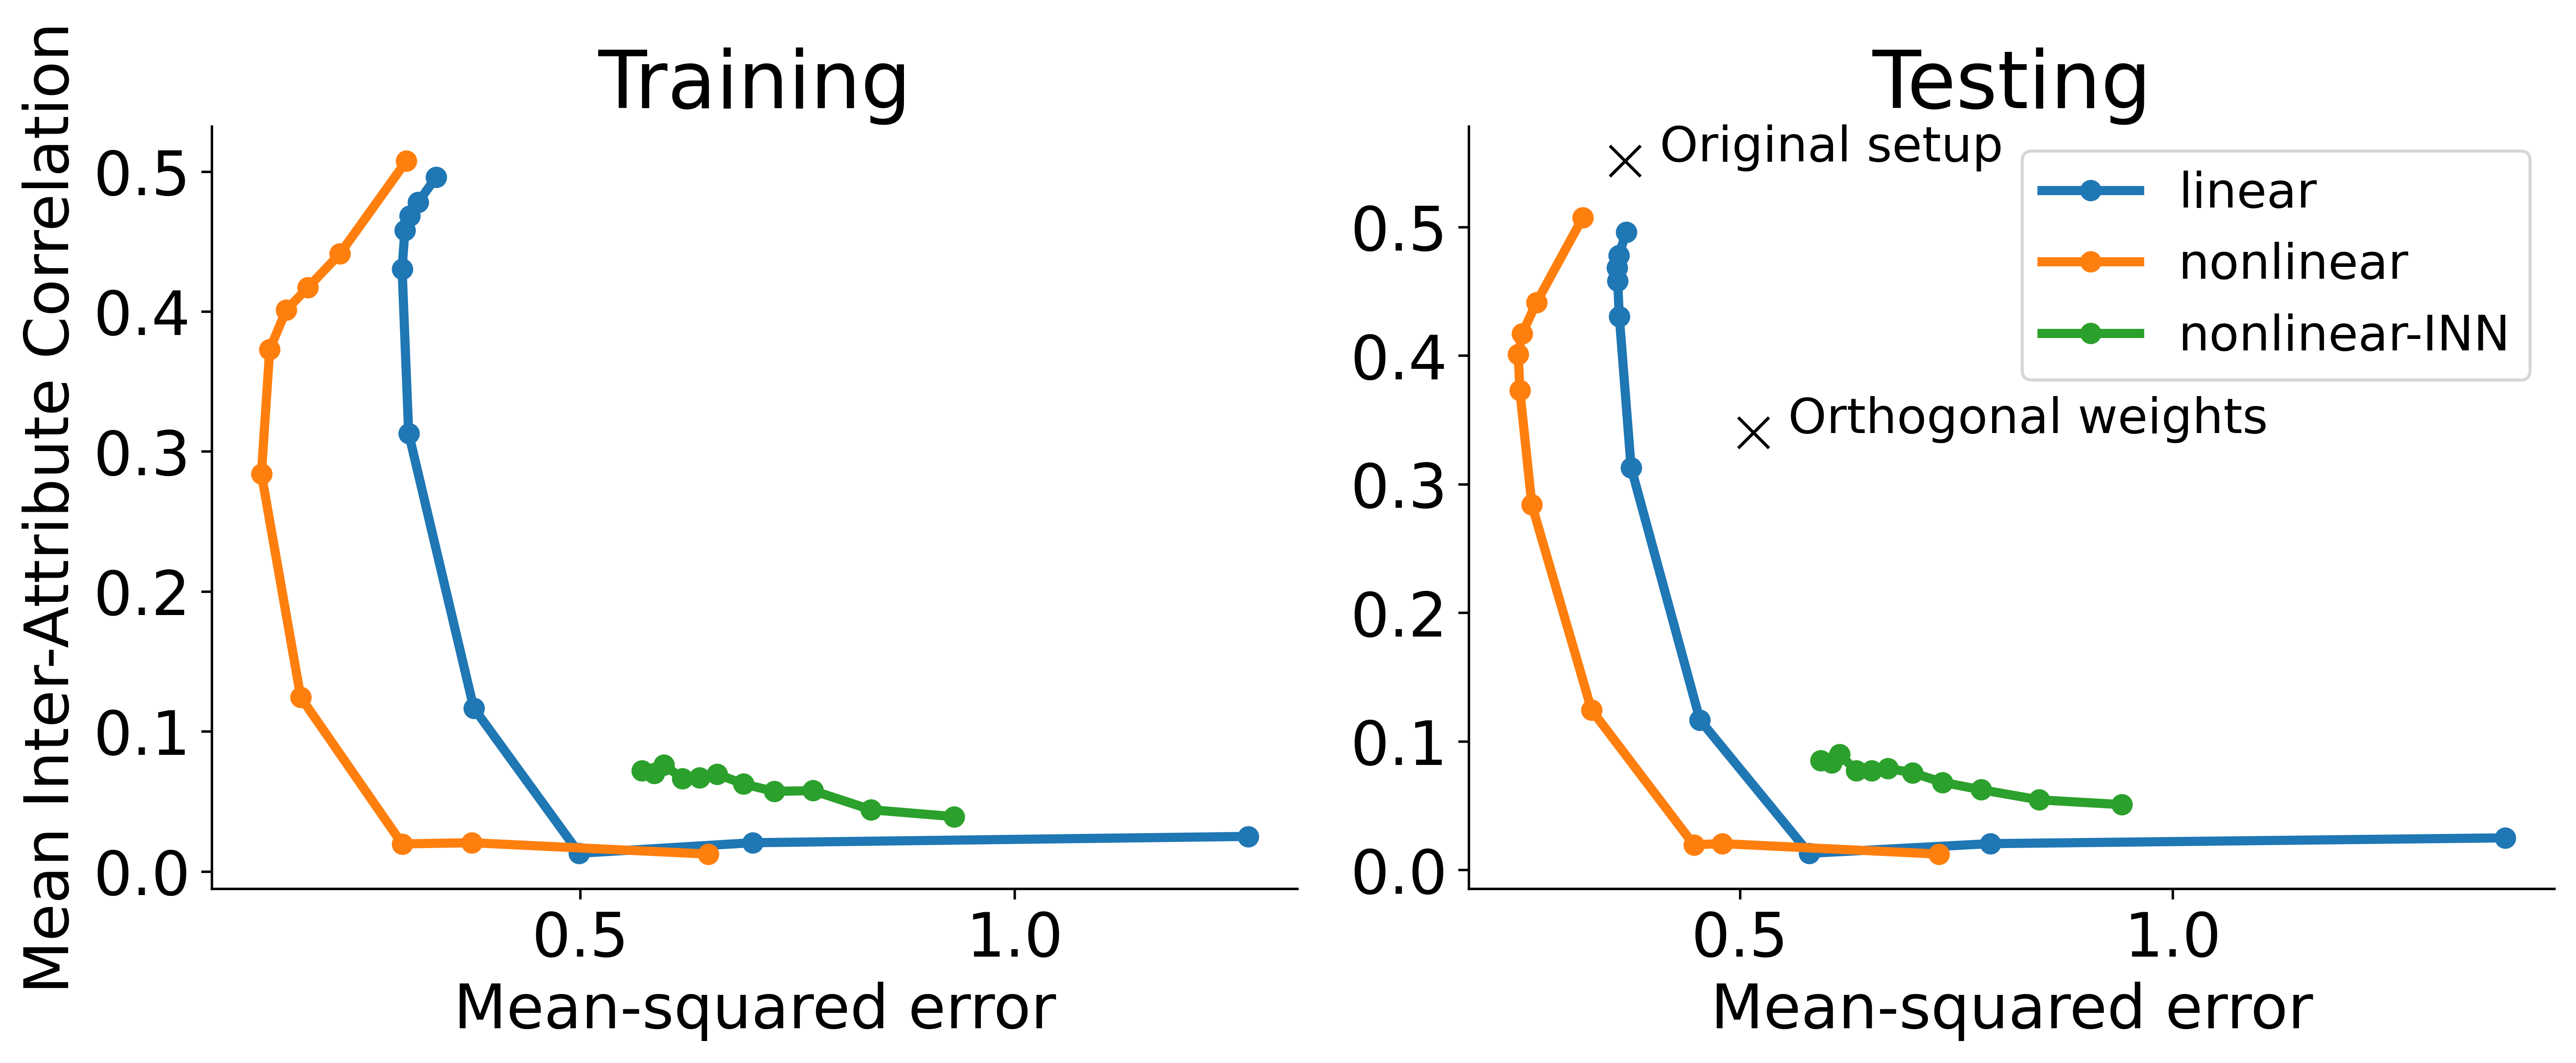

In [45]:
import figs
figs.plot_mse_vs_corrs()

**we are plotting mse but spearman corr probably makes more sense**

In [ ]:
df

In [ ]:
df = pd.read_pickle(oj(PROCESSED_DIR, '07_df_loss_tradeoff_nonlinear_INN.pkl'))
plt.plot(df['mse'], df['spearman'], label='train')
plt.plot(df['mse_test'], df['spearman_test'], label='test')
plt.xlabel('MSE')
plt.ylabel('spearman corr')
plt.legend()
plt.show()

In [128]:
preds_train = m(torch.Tensor(X_train)).detach().numpy()
preds_test = m(torch.Tensor(X_test)).detach().numpy()
print('shapes', preds_train.shape, preds_test.shape)

shapes (3500, 6) (1500, 6)


-0.06701056051352683
-0.0560786178909151
-0.007059932797258937
0.05037832516859507
0.03442539077078464
-0.03800710654858129


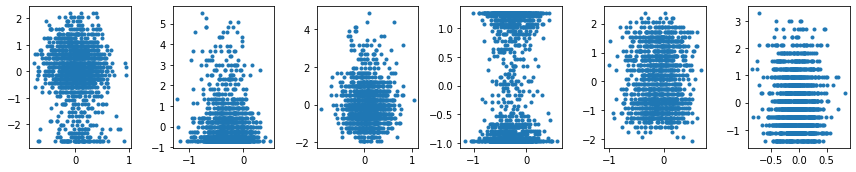

In [129]:
R, C = 1, 6
plt.figure(figsize=(12, 2.5))
for i in range(6):
    plt.subplot(R, C, i + 1)
    plt.plot(preds_test[:, i], y_test[:, i], '.')
    print(scipy.stats.spearmanr(preds_test[:, i], y_test[:, i]).correlation)

plt.tight_layout()
plt.show()

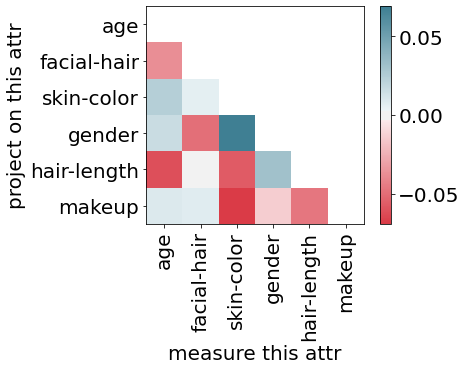

In [135]:
viz.corrplot(np.corrcoef(preds_test.transpose()))
plt.xticks(range(N), attrs, rotation='vertical')
plt.ylabel('project on this attr')
plt.xlabel('measure this attr')
plt.yticks(range(N), attrs)
plt.colorbar()
plt.show()